# Concurrent optimization of orientation and topology

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
from scipy.optimize import bisect

torch.set_default_dtype(torch.double)


from torchfem import Planar
from torchfem.materials import OrthotropicPlaneStress

## Parameters

In [17]:
# Orthotropic material parameters
E_1 = 100000
E_2 = 10000
nu_12 = 0.3
G_12 = 5000

# Mesh parameters
Nx = 60
Ny = 30

# Optimization parameters
p = 3
volfrac = 0.4
move = 0.1
ori_step = 1000.0
V_0 = volfrac * Nx * Ny

## Material model

In [18]:
# Set up a orthotropic material
mat = OrthotropicPlaneStress(E_1=E_1, E_2=E_2, nu_12=nu_12, G_12=G_12)


# Rotation tensor
def R(phi):
    cos = torch.cos(phi)
    cos2 = cos**2
    sin = torch.sin(phi)
    sin2 = sin**2
    sincos = sin * cos
    return torch.stack(
        [
            torch.stack([cos2, sin2, 2 * sincos]),
            torch.stack([sin2, cos2, -2 * sincos]),
            torch.stack([-sincos, sincos, cos2 - sin2]),
        ],
    )

## Mesh generation

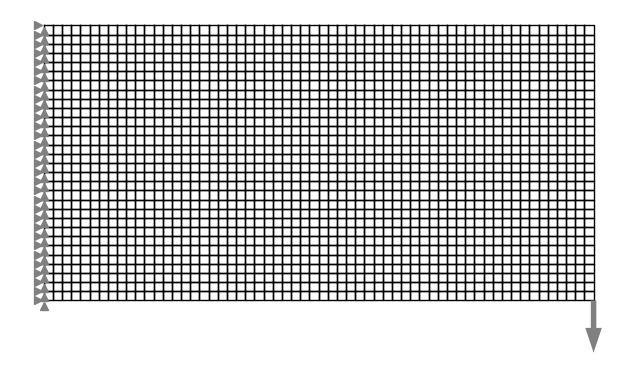

In [19]:
# Create nodes
n1 = torch.linspace(0.0, Nx, Nx + 1)
n2 = torch.linspace(Ny, 0.0, Ny + 1)
n1, n2 = torch.stack(torch.meshgrid(n1, n2, indexing="ij"))
nodes = torch.stack([n1.ravel(), n2.ravel()], dim=1)

# Create elements connecting nodes
elements = []
for j in range(Ny):
    for i in range(Nx):
        n0 = j + i * (Ny + 1)
        elements.append([n0, n0 + 1, n0 + Ny + 2, n0 + Ny + 1])

# Load at top
forces = torch.zeros_like(nodes)
forces[(Nx + 1) * (Ny + 1) - 1, 1] = -1

# Constrained displacement at left end
constraints = torch.zeros_like(nodes, dtype=bool)
displacements = torch.zeros_like(nodes)
constraints[nodes[:, 0] == 0, :] = True

# Thickness
thickness = torch.ones(len(elements))

# Create and plot the domain
beam = Planar(nodes, elements, forces, displacements, constraints, thickness, mat.C())
beam.plot()

## Target function

In [20]:
def compliance(rho, phi):
    beam.C = torch.einsum("..., ij...,jk,lk...->...il", rho**p, R(phi), mat.C(), R(phi))
    u, f = beam.solve()
    return torch.inner(u.ravel(), f.ravel())

## Filter

In [21]:
filter_radius = 1.5
ecenters = torch.stack([torch.mean(nodes[e], dim=0) for e in elements])
dist = torch.cdist(ecenters, ecenters)
H = filter_radius - dist
H[dist > filter_radius] = 0.0

## The optimizer

In [22]:
def optimize(rho, phi, n_iter=100):
    # Bounds
    rho_min = 0.001 * torch.ones_like(rho)
    rho_max = torch.ones_like(rho)

    # Storage for compliance
    energies = []

    for _ in tqdm(range(n_iter)):
        C = compliance(rho, phi)
        dC_dphi = torch.autograd.grad(C, phi, retain_graph=True)[0]
        dC_drho = torch.autograd.grad(C, rho)[0]
        dC_drho = H @ (rho * dC_drho) / H.sum(dim=0) / rho

        # For a certain value of mu, apply the iteration scheme
        def make_step(mu):
            G_k = -dC_drho / mu
            upper = torch.min(rho_max, (1 + move) * rho)
            lower = torch.max(rho_min, (1 - move) * rho)
            rho_trial = G_k**0.5 * rho
            return torch.max(torch.min(rho_trial, upper), lower)

        # Constraint function
        def g(mu):
            rho_k = make_step(mu)
            return rho_k.sum() - V_0

        # Find the root of g(mu)
        with torch.no_grad():
            mu = bisect(g, 1e-10, 100.0)

        # Advance rho and phi
        rho.data = make_step(mu)
        phi.data -= ori_step * dC_dphi.data

        # Track compliance
        with torch.no_grad():
            energies.append(C.item())
    return energies

In [23]:
@torch.no_grad()
def plot_solution(rho, phi):
    # Compute properties
    centers = beam.nodes[beam.elements, :].mean(dim=1)
    dir = torch.stack([torch.cos(phi), -torch.sin(phi), torch.zeros_like(phi)]).T

    # Plot orientations
    beam.plot(element_property=rho, linewidth=0.2, cmap="gray_r")
    plt.quiver(
        centers[:, 0],
        centers[:, 1],
        dir[:, 0],
        dir[:, 1],
        pivot="middle",
        headlength=0,
        headaxislength=0,
        headwidth=0,
        width=0.003,
        color="lightskyblue",
        alpha=rho,
    )
    plt.show()

## Optimize with fibers initially aligned in x 

In [24]:
# Design variables
phi = 0.0 * torch.ones((len(beam.elements)), requires_grad=True)
rho = volfrac * torch.ones((len(beam.elements)), requires_grad=True)

100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


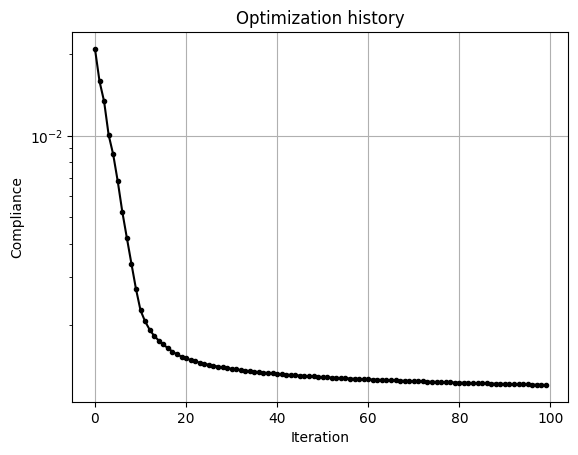

In [25]:
energies = optimize(rho, phi, 200)
plt.semilogy(energies, ".-k")
plt.grid()
plt.title("Optimization history")
plt.xlabel("Iteration")
plt.ylabel("Compliance")
plt.show()

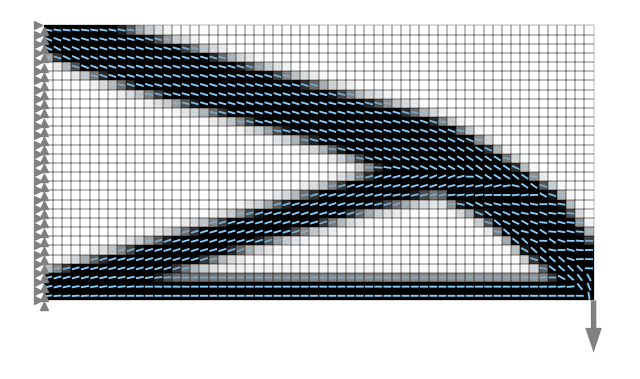

In [26]:
plot_solution(rho, phi)

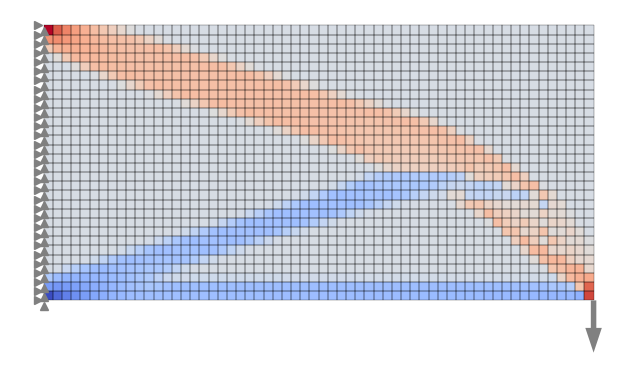

In [49]:
u, f = beam.solve()
stress = beam.compute_stress(u)
e = torch.stack(
    [torch.linalg.eigvalsh(torch.tensor([[s[0], s[2]], [s[2], s[1]]])) for s in stress]
)
mag, pos = torch.max(torch.abs(e), dim=1)
pval = torch.tensor([ev[p] for ev, p in zip(e, pos)])
beam.plot(element_property=pval, cmap="coolwarm", linewidth=0.2)

## Optimize with fibers initially aligned in y

100%|██████████| 250/250 [00:36<00:00,  6.94it/s]


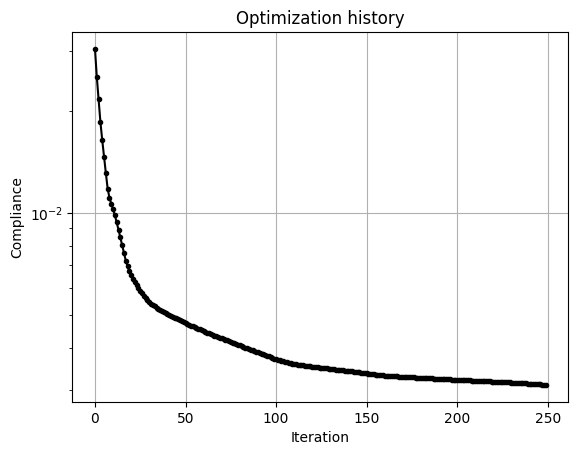

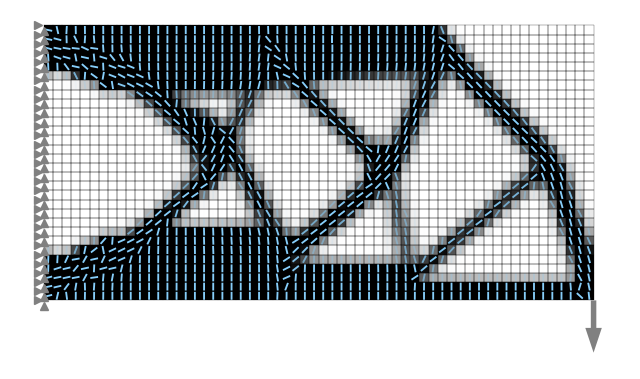

In [ ]:
# Design variables
phi = np.pi / 2 * torch.ones((len(beam.elements)), requires_grad=True)
rho = volfrac * torch.ones((len(beam.elements)), requires_grad=True)

energies = optimize(rho, phi, 250)
plt.semilogy(energies, ".-k")
plt.grid()
plt.title("Optimization history")
plt.xlabel("Iteration")
plt.ylabel("Compliance")
plt.show()

plot_solution(rho, phi)

## Optimize with random initial fibers

100%|██████████| 250/250 [00:36<00:00,  6.80it/s]


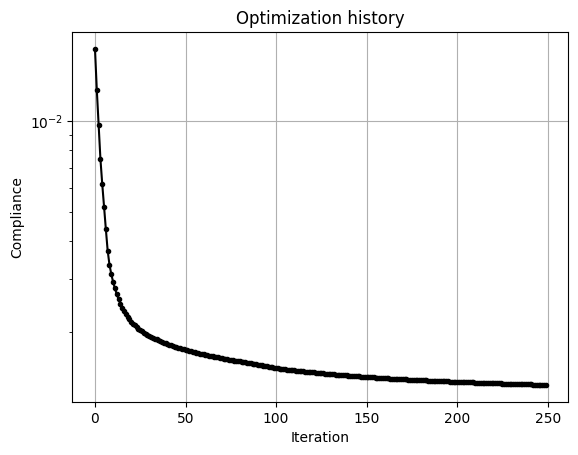

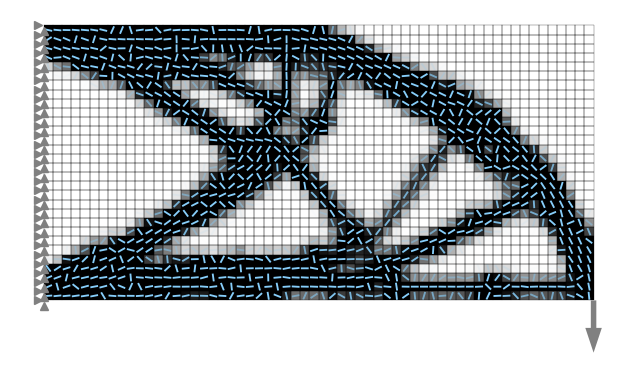

In [ ]:
# Design variables
phi = 2.0 * np.pi * torch.rand((len(beam.elements)), requires_grad=True)
rho = volfrac * torch.ones((len(beam.elements)), requires_grad=True)

energies = optimize(rho, phi, 250)
plt.semilogy(energies, ".-k")
plt.grid()
plt.title("Optimization history")
plt.xlabel("Iteration")
plt.ylabel("Compliance")
plt.show()

plot_solution(rho, phi)